In [35]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import report_ensemble
from diabnet.ensemble import Ensemble
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import bootstrap
import scipy.stats as st
# warnings.simplefilter(action='ignore', category=FutureWarning)
# sns.set_style("whitegrid")
sns.set_style("ticks",{'axes.grid': True,'grid.color': '.95', 'grid.linestyle': '-', 'grid.zorder': 0})
# sns.set_style("ticks",{'axes.grid': True,'grid.color': '.95', 'grid.linestyle': '--'})
COLORS = sns.color_palette("colorblind")



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
ensemble = Ensemble('../data/models/model-positive-13-adamw-lc5-2021-03-03')

../data/models/model-positive-13-adamw-lc5-2021-03-03


In [77]:
r = report_ensemble.DiabNetReport(ensemble, "positivo_1000_random_0.csv")

NEGATIVE FILE ../data/datasets/visits_sp_unique_test_positivo_1000_random_0_negatives_older60.csv


In [78]:
def ece_mce_t_p(preds, targets, bins=10):
    lower_bound = np.arange(0.0, 1.0, 1.0/bins)
    upper_bound = lower_bound + 1.0/bins
    
    ece = np.zeros(1)
    mce = np.zeros(1)
    t = np.zeros(bins)
    p = np.zeros(bins)
    interval_min = np.zeros(bins)
    interval_max = np.zeros(bins)
    
    
    
    for i in range(bins):
        mask = (preds > lower_bound[i]) * (preds <= upper_bound[i])
        if np.any(mask):
#             print(lower_bound[i], upper_bound[i])
#             print(preds[mask])
#             print(targets[mask])
            t[i] = np.mean(targets[mask])
            p[i] = np.mean(preds[mask])
            # num of bootstraps is equal to  
#             data = bootstrap(targets[mask], bootnum=10000, bootfunc=lambda x: np.mean(x) - t[i])
            data = bootstrap(targets[mask], bootnum=10000, bootfunc=lambda x: np.mean(x))
            data = np.sort(data)
#             np.sort(data)
            #print(st.sem(data))
            #interval_min[i], interval_max[i] = st.t.interval(alpha=0.95, df=len(data)-1, loc=t[i], scale=st.sem(data))
#             t[i], _, _, ci = jackknife_stats(targets[mask], np.mean, 0.95)
#             interval_min[i], interval_max[i] = data[249], data[9749]
            interval_min[i], interval_max[i] = data[249]-t[i], data[9749]-t[i]
            delta = np.abs(np.mean(preds[mask]) - np.mean(targets[mask]))
            ece += delta * np.mean(mask)
            mce = np.maximum(mce, delta)
#             print(ece, mce)
            
#     print(interval_min)
#     print(interval_max)
    return ece, mce, t, p, np.stack([np.abs(interval_min), interval_max])

In [79]:
df = pd.DataFrame(r.dataset_test_unique.features)
df.columns = r.feat_names
df['T2D'] = r.dataset_test_unique.labels
df['Pred'] = r.dataset_test_unique.predictions
# correction for soft_label_baseline
# baseline = 0.20
# df['Pred'] = (r.dataset_test_unique.predictions - 0.33)/(0.9 - 0.33)

In [80]:
# df = pd.DataFrame(r.dataset_test_first_diag.features)
# df.columns = r.feat_names
# df['T2D'] = r.dataset_test_first_diag.labels
# df['Pred'] = r.dataset_test_first_diag.predictions

In [81]:
# r.dataset_test_first_diag.df

In [82]:
# df = pd.DataFrame(r.dataset_test_unique_subset_older50.features)
# df.columns = r.feat_names
# df['T2D'] = r.dataset_test_unique_subset_older50.labels
# df['Pred'] = r.dataset_test_unique_subset_older50.predictions

In [83]:
df

,snp_8_133462953,snp_2_91635413,snp_9_25963828,snp_1_17764169,snp_12_41767967,snp_4_49530811,snp_2_96519717,snp_7_116910447,snp_18_56742728,snp_3_75912490,...,snp_20_50189624,snp_1_143276644,snp_16_9536673,snp_20_25734788,AGE,sex,mo_t2d,fa_t2d,T2D,Pred
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,51,M,2,2,1,0.901883
1,0,0,0,1,0,1,1,0,0,1,...,1,1,0,1,40,F,0,1,0,0.086617
2,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,52,F,0,2,1,0.422955
3,0,0,0,0,0,1,0,0,0,0,...,1,1,0,0,34,M,0,1,0,0.034907
4,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,37,F,1,1,0,0.014082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,0,2,0,1,0,1,1,0,0,0,...,0,1,0,1,36,M,1,0,0,0.029540
546,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,41,M,0,2,0,0.405025
547,0,0,1,0,0,0,0,0,0,0,...,2,0,0,0,67,F,2,2,0,0.064399
548,0,0,1,1,0,1,1,0,0,1,...,1,1,0,1,41,F,0,2,0,0.214895


In [84]:
BINS=10
ece, mce, t, p, ece_ci = ece_mce_t_p(df['Pred'].values, df['T2D'].values, bins=BINS)

In [85]:
print(ece, mce)
ece_ci

[0.09599662] [0.19309005]


array([[0.00934579, 0.03809524, 0.06896552, 0.09677419, 0.125     ,
        0.15789474, 0.13888889, 0.17391304, 0.        , 0.        ],
       [0.01869159, 0.04761905, 0.08045977, 0.09677419, 0.125     ,
        0.15789474, 0.11111111, 0.13043478, 0.        , 0.        ]])

(-0.0, 1.0)

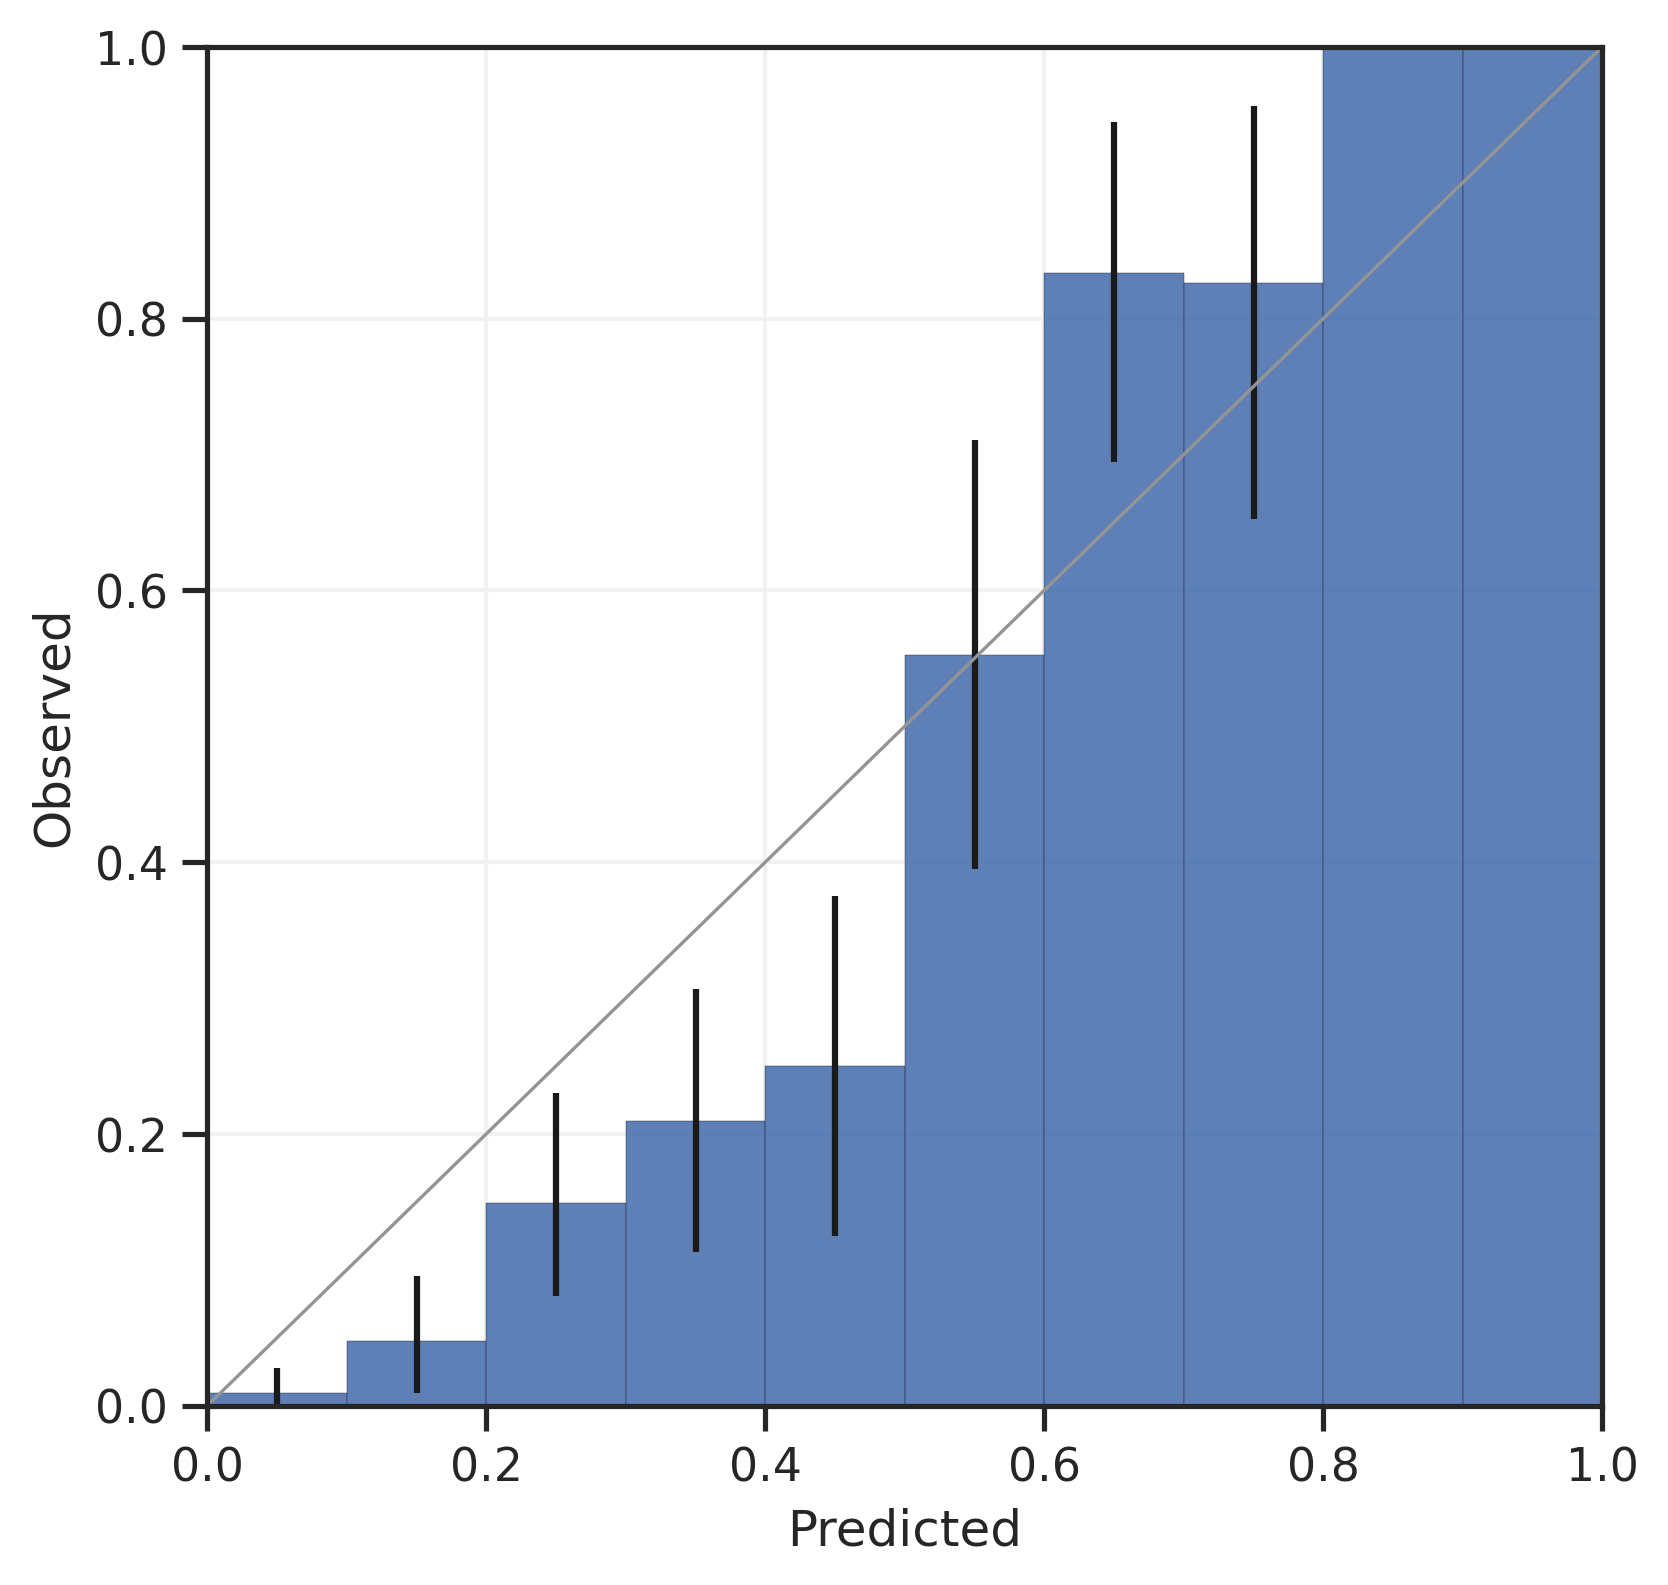

In [86]:
plt.figure(figsize=(6,6), dpi=300)
width = 1.0/BINS
xs = np.arange(width/2,1,width)
plt.bar(xs,t,width, yerr=ece_ci, align='center', linewidth=0.1, alpha=0.9, edgecolor='k')
plt.plot([0,1],[0,1], color=COLORS[7], linewidth=.8)
plt.ylabel("Observed")
plt.xlabel("Predicted")
plt.ylim(-0.0,1.0)
plt.xlim(-0.0,1.0)

## Mean calibration

In [87]:
df['T2D'].mean(), df['Pred'].mean()

(0.28363636363636363, 0.3353797)

<AxesSubplot:>

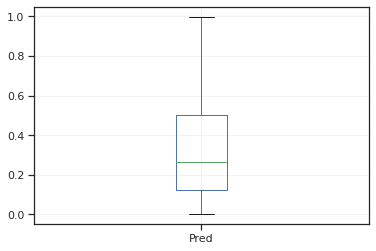

In [88]:
df['Pred'].plot.box()

In [89]:
df['Pred'].describe()

count    550.000000
mean       0.335380
std        0.261708
min        0.000000
25%        0.123605
50%        0.264554
75%        0.504226
max        0.998282
Name: Pred, dtype: float64

In [90]:
df[df["T2D"] == 1].describe()

,T2D,Pred
count,156.0,156.000000
mean,1.0,0.626055
std,0.0,0.235068
min,1.0,0.083016
25%,1.0,0.458391
50%,1.0,0.643652
75%,1.0,0.809719
max,1.0,0.998282


In [91]:
df[df["T2D"] == 0].describe()

,T2D,Pred
count,394.0,394.000000
mean,0.0,0.220290
std,0.0,0.164520
min,0.0,0.000000
25%,0.0,0.090924
50%,0.0,0.190272
75%,0.0,0.314712
max,0.0,0.784522


(array([85., 87., 71., 51., 37., 30., 15.,  9.,  5.,  4.]),
 array([0.        , 0.07845221, 0.15690443, 0.23535663, 0.31380886,
        0.39226106, 0.47071326, 0.5491655 , 0.6276177 , 0.7060699 ,
        0.7845221 ], dtype=float32),
 <BarContainer object of 10 artists>)

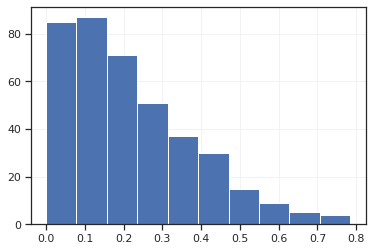

In [92]:

plt.hist(df[df["T2D"] == 0].Pred)

(array([ 5.,  8., 13., 13., 15., 20., 26., 17., 19., 20.]),
 array([0.08301596, 0.17454256, 0.26606917, 0.35759577, 0.44912237,
        0.540649  , 0.63217556, 0.7237022 , 0.8152288 , 0.9067554 ,
        0.998282  ], dtype=float32),
 <BarContainer object of 10 artists>)

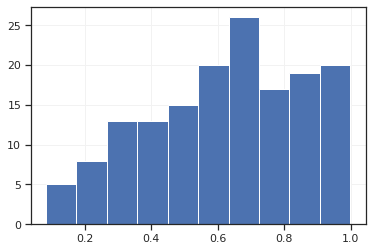

In [93]:
plt.hist(df[df["T2D"] == 1].Pred)

(array([109., 105.,  86.,  63.,  48.,  38.,  35.,  24.,  16.,  26.]),
 array([0.        , 0.0998282 , 0.1996564 , 0.2994846 , 0.3993128 ,
        0.499141  , 0.5989692 , 0.6987974 , 0.7986256 , 0.89845383,
        0.998282  ], dtype=float32),
 <BarContainer object of 10 artists>)

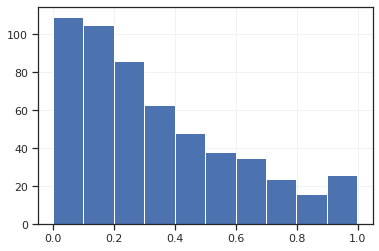

In [94]:
plt.hist(df.Pred)

In [95]:
# plt.hist(df[df['T2D']==1]['Pred'])

In [96]:
# df[(df['T2D']==1)&(df['Pred']>0.5)].count()